<a href="https://colab.research.google.com/github/LauraQ220/IoTGit/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is intended to provide an basic example of how to load and perform some basic preprocessing to histological (.mrxs) hyperspectral data (ENVI format) using Python.

This notebook was designed as a basic demonstration on how to load the data corresponding to the HistologyHSI-BRCA-Recurrence
 ([HistologyHSI-BRCA-Recurrence](DOI)). CAMBIAR LINK

# 1) Setting up the environment and downloading the example data

### Libraries:
The libraries required for this notebook are Spectral Python (SPy), NumPy, SciPy, and Matplotlib.

> Spectral Python (SPy). Python module for hyperspectral image processing. https://www.spectralpython.net

> Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). https://doi.org/10.1038/s41586-020-2649-2

> J. D. Hunter, "Matplotlib: A 2D Graphics Environment," in Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, May-June 2007, doi: 10.1109/MCSE.2007.55.

> Virtanen, P., Gommers, R., Oliphant, T.E. et al. SciPy 1.0: fundamental algorithms for scientific computing in Python. Nat Methods 17, 261–272 (2020). https://doi.org/10.1038/s41592-019-0686-2





### Data:

In this tutorial, the data is directly downloaded from the TCIA using ascli. For more information on how to download data from TCIA, please consult this notebook: https://github.com/kirbyju/TCIA_Notebooks/blob/main/TCIA_Aspera_CLI_Downloads.ipynb.

The data used on this notebook correspond to a folder containing hyperspectral data from a brain histological slide from the HistologyHSI-GB dataset.  The hyperspectral cubes from the histological slide and the white and dark references are stored as ENVI files, the standard format for storing hyperspectral images. The ENVI format consists of a flat-binary raster file with an accompanying ASCII header file.

The folder contains the ENVI files from the histological slide and the necessary files for the calibration (dark and white reference). Additionally, the folder contains a synthetic RGB image extracted from the hyperspectral cube.



In [1]:
# Install the Spectral Python (SPy) library
!pip install spectral
# Download a folder containing the hyperspectral data from the HistologyHSI-GB dataset from TCIA
#!apt install -y ruby ruby-dev rubygems ruby-json
#!gem install aspera-cli
#!ascli conf ascp install
#!ascli faspex5 packages receive --url= 'https://faspex.cancerimagingarchive.net/aspera/faspex/public/package?context=eyJyZXNvdXJjZSI6InBhY2thZ2VzIiwidHlwZSI6ImV4dGVybmFsX2Rvd25sb2FkX3BhY2thZ2UiLCJpZCI6Ijc2NCIsInBhc3Njb2RlIjoiMGU0MzFhYTFjN2ZhOGMwZWJmNTRhZDVkZTQxOGY5NWVlNmYyMjhlNiIsInBhY2thZ2VfaWQiOiI3NjQiLCJlbWFpbCI6ImhlbHBAY2FuY2VyaW1hZ2luZ2FyY2hpdmUubmV0In0=' P1/ROI_01_C01_T

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.3 MB/s eta 0:00:00


In [2]:
!wget -O downloaded_file.zip 'https://nimbus.iuma.ulpgc.es/s/Sqddxwd5mCefRke/download'
!unzip downloaded_file.zip
!rm downloaded_file.zip

--2025-01-27 13:23:12--  https://nimbus.iuma.ulpgc.es/s/Sqddxwd5mCefRke/download
Resolving nimbus.iuma.ulpgc.es (nimbus.iuma.ulpgc.es)... 193.145.147.66
Connecting to nimbus.iuma.ulpgc.es (nimbus.iuma.ulpgc.es)|193.145.147.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘downloaded_file.zip’

downloaded_file.zip     [    <=>             ]   1.81G  11.7MB/s    in 2m 44s  

2025-01-27 13:25:58 (11.3 MB/s) - ‘downloaded_file.zip’ saved [1940236491]

Archive:  downloaded_file.zip
   creating: HS_VNIR_15_IDC_x10_C01/
 extracting: HS_VNIR_15_IDC_x10_C01/RGBImage.png  
 extracting: HS_VNIR_15_IDC_x10_C01/SyntheticRGBImage.png  
 extracting: HS_VNIR_15_IDC_x10_C01/calibrated.dat  
 extracting: HS_VNIR_15_IDC_x10_C01/calibrated.hdr  
 extracting: HS_VNIR_15_IDC_x10_C01/darkReference.dat  
 extracting: HS_VNIR_15_IDC_x10_C01/darkReference.hdr  
 extracting: HS_VNIR_15_IDC_x10_C01/raw.dat  
 extracting: HS_VNIR_15_IDC_x10_C01/r

# 2) Define helper functions to load and preprocessing the hyperspectral data

In [3]:
#########################################################
## Helper functions for loading and preprocessing data ##
#########################################################

import numpy as np
from spectral import *
import scipy


def read_hyperspectral_cube(file_name):
    """Function used to read an ENVI hyperspectral image, and return a numpy
    data structure containing the 3D hyperspectral cube

    Parameters
    ----------
    file_name : str
        The file location of the ENVI header related to the hyperspectral data.

    Returns
    -------
    hyperspectral_data: ndarray
        3-dimensional numpy array containing the hyperspectral cube
    wavelengths: ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube
    """

    ENVI_structure = envi.open(file_name)
    hyperspectral_data = ENVI_structure.load()
    wavelengths = ENVI_structure.bands.centers
    return hyperspectral_data, wavelengths

def hyperspectral_calibration(raw_data, white_reference, dark_reference):
    """Perform the calibration of a hyperspectral imaging using a white and
    dark reference images.

    Parameters
    ----------
    raw_data : ndarray
        Array containing the raw hyperspectral cube
    white_reference : ndarray
        Array containing the white reference
    dark_reference : ndarray
        Array containing the dark reference
    Returns
    -------
    ndarray
        Calibrated hyperspectral cube
    """
    return (raw_data-dark_reference)/(white_reference-dark_reference)

def band_reduction(input_data, wavelengths, n = 3):
    """Perform the band reduction to the hyperspectral cube

    Parameters
    ----------
    input_data : ndarray
        Array containing the raw hyperspectral cube
    wavelengths : ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube
    n : Integer
        Width of the window used for the moving average window.
    Returns
    -------
    band_reduced_cube: ndarray
        3-dimensional numpy array containing the hyperspectral cube after the
        band reduction
    wavelength_reduced: ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube after the band reduction
    """
    w = np.ones(n)/n
    moving_averaged_image = scipy.ndimage.convolve1d(calibrated_hyperspectral_image, w, axis=2)
    band_reduced_cube = moving_averaged_image[:,:,1:-1:n]
    wavelength_reduced = wavelenghts[1:-1:n]
    return band_reduced_cube, wavelength_reduced

# 3) Load the hyperspectral images and check their sizes:

The raw hyperspectral image has a dimension of (800, 1004, 826), where the first two dimensions correspond to the spatial information (800x1004 pixels), and the third dimension corresponding to the spectral information (826 bands).

The white and dark reference have a dimension of (1, 1004, 826), since there is only information about a single line across the field of view of the camera. These reference were obtained as an average of 100 consecutive measurements of the white and dark references.

In [4]:
# Define the file names for the raw image, the white reference and the dark
# reference.
raw_file_name = 'HS_VNIR_15_IDC_x10_C01/raw.hdr'
white_reference_file_name = 'HS_VNIR_15_IDC_x10_C01/whiteReference.hdr'
dark_reference_file_name = 'HS_VNIR_15_IDC_x10_C01/darkReference.hdr'
calibrated_file_name = 'HS_VNIR_15_IDC_x10_C01/calibrated.hdr'

# Use the function read_hyperspectral_cube to load the ENVI files into numpy
# arrays. The spectral bands (wavelengths) for the white and dark references
# are the same ones we have for the hyperspectral cube, so it is no necesary
# to also get them.
raw_hyperspectral_image, wavelenghts = read_hyperspectral_cube(raw_file_name)
white_reference, _ = read_hyperspectral_cube(white_reference_file_name)
dark_reference, _ = read_hyperspectral_cube(dark_reference_file_name)
calibrated_hyperspectral_image, _ = read_hyperspectral_cube(calibrated_file_name)

# Display data dimensions:
print("Raw hyperspectral image dimensions: " + str(raw_hyperspectral_image.shape))
print("White reference dimensions: " + str(white_reference.shape))
print("Dark reference dimensions: " + str(dark_reference.shape))
print("Calibrated hyperspectral image dimensions: " + str(calibrated_hyperspectral_image.shape))

# Display some information about the spectral bands:
print("Min. wavelength (nm): " + str(wavelenghts[0]))
print("Max. wavelength (nm): " + str(wavelenghts[-1]))
print("Distance between consecutive spectral bands (nm): " + str(np.mean(np.diff(wavelenghts))))

Raw hyperspectral image dimensions: (600, 1004, 740)
White reference dimensions: (1, 1004, 740)
Dark reference dimensions: (100, 1004, 740)
Calibrated hyperspectral image dimensions: (600, 1004, 740)
Min. wavelength (nm): 400.482
Max. wavelength (nm): 938.16
Distance between consecutive spectral bands (nm): 0.7275751014884978


# 4) Perform the calibration and the preprocessing:

In [6]:
# Perform the hyperspectral image calibration
#calibrated_hyperspectral_image = hyperspectral_calibration(raw_hyperspectral_image, white_reference, dark_reference)

# TODO: Optional. Perform the band reduction.
band_reduced_hyperspectral_image, reduced_wavelengths = band_reduction(calibrated_hyperspectral_image, wavelenghts)

# Display data dimensions:
print("Calibrated hyperspectral image dimensions: " + str(calibrated_hyperspectral_image.shape))
print("Band-reduced hyperspectral image dimensions: " + str(band_reduced_hyperspectral_image.shape))

# Display some information about the reduced spectral bands:
print("Min. wavelength (nm): " + str(reduced_wavelengths[0]))
print("Max. wavelength (nm): " + str(reduced_wavelengths[-1]))
print("Distance between consecutive spectral bands (nm): " + str(np.mean(np.diff(reduced_wavelengths))))

Calibrated hyperspectral image dimensions: (600, 1004, 740)
Band-reduced hyperspectral image dimensions: (600, 1004, 246)
Min. wavelength (nm): 401.21
Max. wavelength (nm): 935.977
Distance between consecutive spectral bands (nm): 2.1827224489795922


# 5) Representation of the information from the hyprespectral data:
## Visualizing the spatial information for different spectral bands

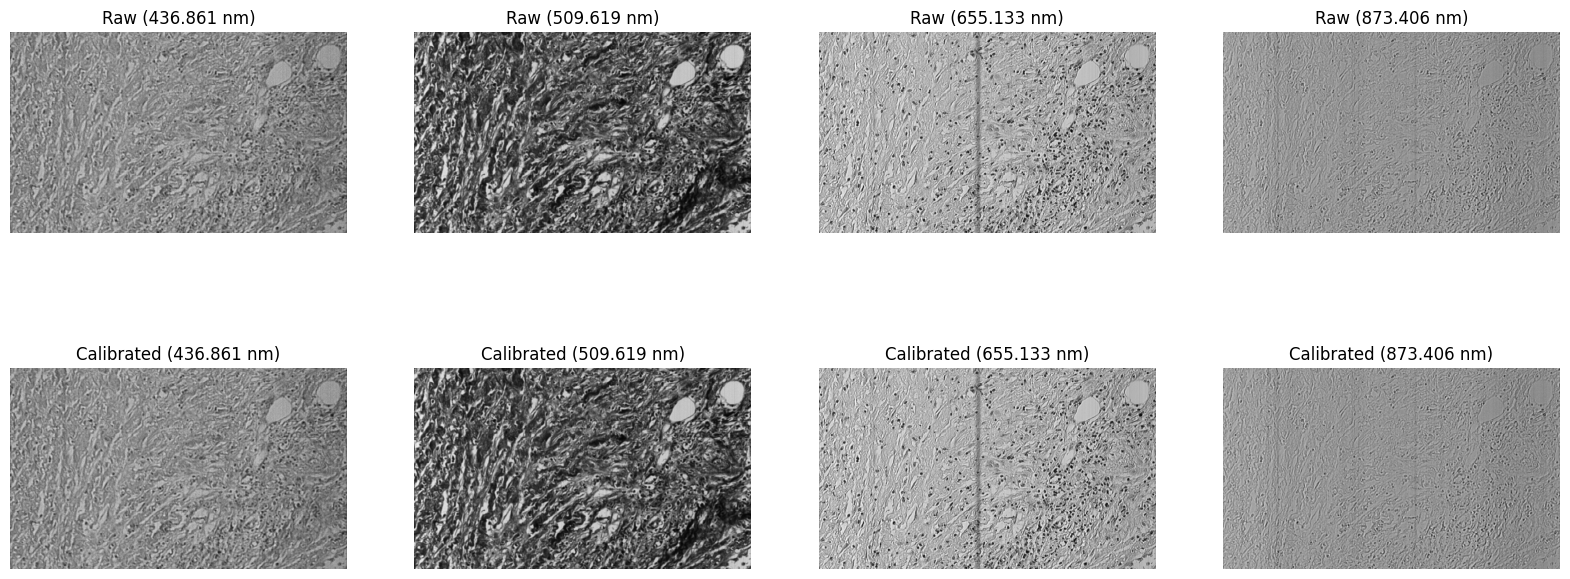

In [7]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2,4, figsize=(20, 8))

# TODO: Make this in a loop:
band_list = [50, 150, 350, 650]

for idx, current_band in enumerate(band_list):
  axarr[0,idx].imshow(raw_hyperspectral_image[:,:,current_band],cmap='gray')
  axarr[0,idx].set_title("Raw (" + str(wavelenghts[current_band]) + " nm)")
  axarr[0,idx].axis('off')

  axarr[1,idx].imshow(calibrated_hyperspectral_image[:,:,current_band],cmap='gray')
  axarr[1,idx].set_title("Calibrated (" + str(wavelenghts[current_band]) + " nm)")
  axarr[1,idx].axis('off')

## Visualizing the spectral information of different pixels

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(16, 4))

x_coordinate = 500
y_coordinate = 600

# Represent some bands from the raw image
axarr[0].plot(wavelenghts, np.squeeze(raw_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[0].set_title("Raw spectra")
axarr[0].set_xlabel("wavelength (nm)")
axarr[0].set_ylabel("Radiance (Digital number)")
axarr[0].set_xlim(wavelenghts[0], wavelenghts[-1])


axarr[1].plot(wavelenghts, np.squeeze(calibrated_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[1].set_title("Calibrated spectra")
axarr[1].set_xlabel("wavelength (nm)")
axarr[1].set_ylabel("Absorbance")
axarr[1].set_xlim(wavelenghts[0], wavelenghts[-1])


axarr[2].plot(reduced_wavelengths, np.squeeze(band_reduced_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[2].set_title("Band-reduced spectra")
axarr[2].set_xlabel("wavelength (nm)")
axarr[2].set_ylabel("Absorbance")
axarr[2].set_xlim(reduced_wavelengths[0], reduced_wavelengths[-1]);

